# Brain MRI detection using simple CNN

### Data import

In [36]:
import kagglehub
import shutil

# 使用 kagglehub 下載數據集
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

# 自定義存放目錄
custom_path = "../../data/MRI_classification"

# 移動數據集到自定義目錄
shutil.move(f'{path}\\brain_tumor_dataset', custom_path)

print(f"Dataset downloaded and moved to: {custom_path}")

100%|██████████| 15.1M/15.1M [00:02<00:00, 7.41MB/s]

Extracting files...


Dataset downloaded and moved to: ../../data/MRI_classification


In [1]:
import os
import pandas as pd
import numpy as np
def filePathsGen(rootPath):
    """此函數將rootPath資料夾目錄中的所有圖片路徑資訊儲存至一個清單內。"""
    paths = []
    dirs = []
    for dirPath, dirNames, fileNames in os.walk(rootPath):
        for fileName in fileNames:
            category = dirPath.split("\\")[-1]  # (Windows)
            fullPath = os.path.join(dirPath, fileName)
            paths.append((category, fullPath))
    return dirs, paths

In [1]:
dirs, paths = filePathsGen("..\\..\\data\\MRI_classification\\")  # 載入圖片路徑 (Windows)
# dirs, paths = filePathsGen("../datasets/mnist/")  # 載入圖片路徑 (Linux, Mac)

dfPath = pd.DataFrame(paths, columns=["class", "path"])  # 圖片路徑存成Pandas資料表
dfPath.head(3)  # 看資料表前3個row

NameError: name 'filePathsGen' is not defined

In [4]:
from sklearn.model_selection import train_test_split

# split dataset into train and val
train, val = train_test_split(
    dfPath, 
    test_size=0.2,   # 設定 val 集比例
    stratify=dfPath['class'],  # 按照 'label' 列分層
    random_state=25  # 固定隨機種子，確保可重現
)

# check class distribution
print(f"Train Distribution:\n{train['class'].value_counts(normalize=True)}")
print(f"Validation Distribution:\n{val['class'].value_counts(normalize=True)}")

Train Distribution:
class
yes    0.613861
no     0.386139
Name: proportion, dtype: float64
Validation Distribution:
class
yes    0.607843
no     0.392157
Name: proportion, dtype: float64


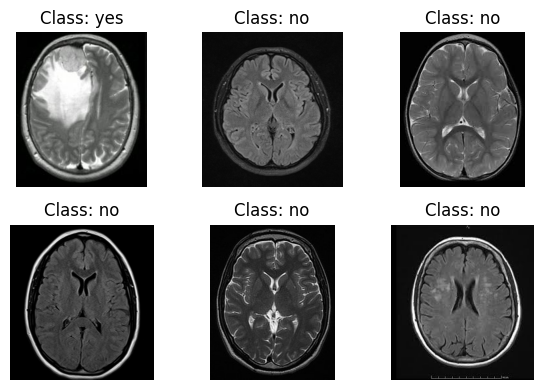

In [5]:
import matplotlib.pyplot as plt

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(6, 4))  # Adjust figsize for overall size

# Loop through the first 6 images
for j, ax in enumerate(axes.flat):  # Flatten the grid for easier iteration
    if j < len(train):  # Ensure we don't exceed the dataset size
        img = plt.imread(train["path"].iloc[j])  # Load the image
        title = train["class"].iloc[j]          # Get the corresponding class label

        ax.imshow(img, cmap="gray")             # Display the image
        ax.set_title(f"Class: {title}")         # Set the title for the subplot
        ax.axis("off")                          # Remove the axis for cleaner display

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()


In [6]:

import numpy as np
import matplotlib.pyplot as plt
import cv2

def dataLoad(dfPath):
    # Extract file paths and initialize lists for images and labels
    paths = dfPath["path"].values
    images = []  # List to store processed images
    labels = []  # List to store corresponding labels

    for j in range(len(paths)):
        # Read the image
        img = plt.imread(paths[j])
        
        # Convert to grayscale if the image is in RGB format
        if len(img.shape) == 3:  # RGB images have shape (H, W, 3)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # RGB to grayscale conversion
        
        # Resize the image to 128x128
        img_resized = cv2.resize(img, (128, 128))  # Use OpenCV for resizing
        
        # Normalize the image to the range [0, 1]
        img_resized = img_resized / 255.0
        images.append(img_resized)  # Add the processed image to the list

        # Convert the label to integer
        label = dfPath["class"].iloc[j]
        labels.append(0 if label == 'no' else 1 )

    # Convert the image and label lists to NumPy arrays
    x = np.array(images, dtype=np.float32)  # Array of processed images
    y = np.array(labels, dtype=np.int64)   # Array of integer labels

    return x, y

# Load training and validation data
trainX, trainY = dataLoad(train)
valX, valY = dataLoad(val)

print(f"Train data shape: {trainX.shape}, Train labels shape: {trainY.shape}")
print(f"Validation data shape: {valX.shape}, Validation labels shape: {valY.shape}")


trainX, trainY = dataLoad(train)
trainValX, trainValY = dataLoad(val)


Train data shape: (202, 128, 128), Train labels shape: (202,)
Validation data shape: (51, 128, 128), Validation labels shape: (51,)


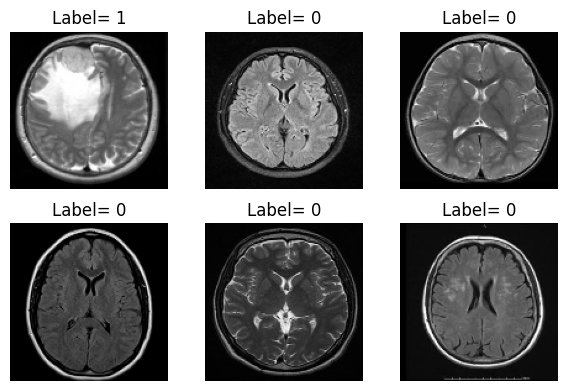

In [7]:
import matplotlib.pyplot as plt

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(6, 4))  # Adjust figsize to control the overall size

# Display the first 6 images
for i, ax in enumerate(axes.flat):  # Flatten the 2x3 grid into a 1D iterator
    ax.imshow(trainX[i, ...], cmap="gray")  # Show the image in grayscale
    ax.set_title(f"Label= {trainY[i]}")    # Set the title for each subplot
    ax.axis("off")  # Turn off axis for cleaner display

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


In [33]:
from torch.nn import Sequential
from torch.nn import Linear, Conv2d, MaxPool2d, Flatten, Dropout, Sigmoid, ReLU
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
import torch

In [39]:
# 轉換NumPy Tensor成為 PyTorch Tensor
x_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
x_val, y_val = torch.tensor(valX), torch.tensor(valY)

# 確立資料型別
x_train = x_train.to(torch.float32).unsqueeze(1)
x_val = x_val.to(torch.float32).unsqueeze(1)
y_train = y_train.to(torch.int64)
y_val = y_val.to(torch.int64)

# 將PyTorch tensor 製作成 Data Loader
td = TensorDataset(x_train, y_train)
dl_train = DataLoader(td, batch_size=32, shuffle=True)

td = TensorDataset(x_val, y_val)
dl_test = DataLoader(td, batch_size=32, shuffle=False)

In [40]:
for x_batch, y_batch in dl_train:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 1, 128, 128]) torch.Size([32])


In [19]:
class MY_CNN:
    """建立一個CNN模型。"""

    def __init__(self, in_shape, out_classes, in_channels=1):

        self.in_channels, self.h, self.w = in_shape
        self.out_classes = out_classes

    def build_model(self):
        """以Sequential()逐層疊加模型。"""
        layers = [
            # conv block 1
            Conv2d(self.in_channels, 32, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2),
            Dropout(0.25),
            # conv block 2
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(
                64, 64, kernel_size=3, padding=1
            ),  # out shape= [N_images, 64, self.h//2, self.w//2]
            MaxPool2d(kernel_size=2),  # out shape= [N_images, 64, self.h//4, self.w//4]
            Dropout(0.25),
            # dense block
            Flatten(),  # out shape= [N_images, 64 * self.h//4 * self.w//4]
            Linear((self.h // 4) * (self.w // 4) * 64, 512),
            ReLU(),
            Dropout(0.5),
            Linear(512, 2),
            Sigmoid()
        ]

        return Sequential(*layers)

In [ ]:
# from Module.model_trainer import SimpleTrainer
class SimpleTrainer:
    """A model trainer for classification models."""

    def __init__(self, model, loss_fn, optimizer):
        self.model = self.to_gpu(model)
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def to_gpu(self, obj, device="cuda:0"):
        """將張量或模型送至GPU。"""
        return obj.to(device)
        # return obj
    

    def train_step(self, dataloader):
        """訓練一個epoch。"""
        self.model.train()  # 設定成訓練模式 (有些網路層訓練時和推理時有不同的行為, 例如Dropout)
        for iteration, (batch_x, batch_y) in enumerate(dataloader):
            batch_x = self.to_gpu(batch_x)
            batch_y = self.to_gpu(batch_y)

            self.optimizer.zero_grad()  # 請優化器清空模型內所有權重的梯度

            pred_y = self.model(batch_x)  # 正向傳遞得到模型預測

            loss_value = self.loss_fn(
                pred_y, batch_y
            )  # 將正確(Ground Truth)和預測(Prediction) 標籤做比較，得到誤差
            loss_value.backward()  # 倒傳遞得到誤差

            self.optimizer.step()  # 讓優化器更新模型權重乙次

        return self.test_step(dataloader, mode="train")

    def test_step(self, dataloader, mode="test"):
        """結束一個epoch的訓練後，測試模型表現。"""
        self.model.eval()  # 設定成推理模式

        size = len(dataloader.dataset)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for iteration, (batch_x, batch_y) in enumerate(dataloader):
                batch_x = self.to_gpu(batch_x)
                batch_y = self.to_gpu(batch_y)

                pred_y = self.model(batch_x)

                test_loss += self.loss_fn(pred_y, batch_y).item()
                correct += (
                    (pred_y.argmax(axis=1) == batch_y).type(torch.float).sum().item()
                )
                

        test_loss /= size
        correct /= size

        print(
            "{}_loss={:.4f}, {}_accuracy={:.10f}".format(mode, test_loss, mode, correct)
        )
        return correct

    def fit(self, dataloader_train, dataloader_test, num_epochs):
        # 開始訓練
        metrics = {"train_acc": [], "test_acc": []}
        for epoch in range(num_epochs):
            print(epoch)
            train_acc = self.train_step(dataloader_train)
            test_acc = self.test_step(dataloader_test)

            metrics["train_acc"].append(train_acc)
            metrics["test_acc"].append(test_acc)

        return metrics

    def __call__(self, x):
        self.model.eval()  # 啟動推理 (Inference) 模式
        return self.model(x)  # 執行推理

In [3]:
# 取得模型架構
net = MY_CNN(in_shape=(1, 128, 128), out_classes=2).build_model()

# 宣告模型訓練設定
num_epochs = 50
learning_rate = 0.05

# 定義優化器, Loss函數
ce_loss = CrossEntropyLoss()
opt = SGD(net.parameters(), lr=learning_rate)

# 開始訓練模|型
model = SimpleTrainer(net, ce_loss, opt)
metrics = model.fit(dl_train, dl_test, num_epochs=num_epochs)

NameError: name 'MY_CNN' is not defined

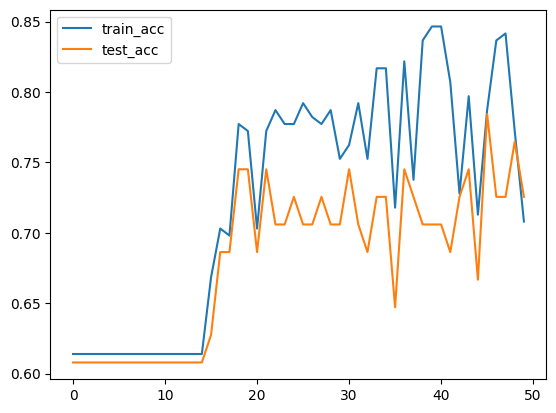

In [42]:
plt.plot(metrics["train_acc"], label="train_acc")
plt.plot(metrics["test_acc"], label="test_acc")
plt.legend()
plt.show()